In [1]:
# make calendar maps
!pip install calmap

In [6]:
!pip install squarify

In [1]:
import calmap

In [4]:
# Main libraries that we will use in this kernel
import datetime
import numpy as np
import pandas as pd

# # garbage collector: free some memory is needed
import gc
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# pip install squarify (algorithm for treemap) if missing
import squarify

# statistical package and some useful functions to analyze our timeseries
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.stattools as stattools

import time

from xgboost import XGBRegressor
from string import punctuation
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression

def print_files():
    import os
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))

import warnings
warnings.filterwarnings("ignore")

In [9]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

# Fix shops df and generate some features

In [3]:
# import the df
shops = pd.read_csv("competitive-data-science-predict-future-sales/shops.csv")
shops.shape

(60, 2)

In [11]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [12]:
# We don't have any duplicates in the shop_name field
shops.shape[0] == len(shops["shop_name"].unique())

True

In [13]:
# No missing values in the shops df
shops.isnull().sum().sum()

0

In [6]:
# let's correct the shops df and also generate a few more features
def fix_shops(shops):
    '''
    This function modifies the shops df inplace.
    It correct's 3 shops that we have found to be 'duplicates'
    and also creates a few more features: extracts the city and encodes it using LabelEncoder
    '''
    
    d = {0:57, 1:58, 10:11, 23:24}
    
    # this 'tricks' allows you to map a series to a dictionary, but all values that are not in the dictionary won't be affected
    # it's handy since if we blindly map the values, the missings values will be replaced with nan
    shops["shop_id"] = shops["shop_id"].apply(lambda x: d[x] if x in d.keys() else x)
    
    # replace all the punctuation in the shop_name columns
    shops["shop_name_cleaned"] = shops["shop_name"].apply(lambda s: "".join([x for x in s if x not in punctuation]))
    
    # extract the city name
    shops["city"] = shops["shop_name_cleaned"].apply(lambda s: s.split()[0])
    
    # encode it using a simple LabelEncoder
    shops["city_id"] = LabelEncoder().fit_transform(shops['city'])

In [5]:
fix_shops(shops)

In [6]:
shops.head()

,shop_name,shop_id,shop_name_cleaned,city,city_id
0,"!Якутск Орджоникидзе, 56 фран",57,Якутск Орджоникидзе 56 фран,Якутск,29
1,"!Якутск ТЦ ""Центральный"" фран",58,Якутск ТЦ Центральный фран,Якутск,29
2,"Адыгея ТЦ ""Мега""",2,Адыгея ТЦ Мега,Адыгея,0
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха ТРК ОктябрьКиномир,Балашиха,1
4,"Волжский ТЦ ""Волга Молл""",4,Волжский ТЦ Волга Молл,Волжский,2


# Category

In [7]:
# import df
items_category = pd.read_csv("competitive-data-science-predict-future-sales/item_categories.csv")
items_category.shape

(84, 2)

In [18]:
items_category.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [19]:
# We don't have any duplicates in the item_category_name field
items_category.shape[0] == len(items_category["item_category_name"].unique())

True

In [20]:
# allow pandas to show all the rows from this df
pd.options.display.max_rows = items_category.shape[0]

In [22]:
# If we take a closer look, we can see that we have a lot of Play Station categories: like accesories, games and so on. We have the same categories for XBOX and also for PC Games.
# A lot of categories have to deal with books, presents and computer software and music (CD).
# We will generate later some features by parsing the names and making groupedby features.
items_category

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
5,Аксессуары - PSVita,5
6,Аксессуары - XBOX 360,6
7,Аксессуары - XBOX ONE,7
8,Билеты (Цифра),8
9,Доставка товара,9


data Analysis.ipynb
+
C
Code
57
Music
-
MRZ
5 /
58
Music
-
Vinyl
58
59
Music
-
Music video
59
60
Music
-
Gift edition
60
61
Gifts
-
Attributes
61
62
Gifts
-
Gadgets,
robots,
sports
62
63
Gifts
-
Soft
toys
63
64
Gifts
-
Board game
64
65
Gifts
-
Board game
(compact)
65
66
Gifts
-
Postcards,
stickers
66
67
Gifts
-
Development
67
68
Gifts
-
Certificates,
services
68
69
Gifts
-
Souvenirs
69
70
Gifts
-
Souvenirs
(in
bulk)
70
71
Gifts
-
Bags,
Albums,
Mouse pads
71
72
Gifts
-
Figurines
72
73
Programs
-
1C:
Enterprise
8
73
74
Programs
-
MAC
(Digit)
74
75
Programs
-
For
home
and
office use
75
76
Programs
-
For
home
and
office use
(Figure)
76
77
Pr
Programs
-
Teaching
77
78
Programs
-
Teaching
(Figure)
78
79
Service
79
80
Service
-
Tickets
80
81
Clean
media
(spire)
81
82
Clean
media
(piece)
82
Elements

In [23]:
# If we apply a simple lambda function and extract the everything that contains PS, we will get 16 different categories for PlayStation
items_category["PS_flag"] = items_category["item_category_name"].apply(lambda x: True if "PS" in x else False)
items_category[items_category["PS_flag"] == True]

,item_category_name,item_category_id,PS_flag
1,Аксессуары - PS2,1,True
2,Аксессуары - PS3,2,True
3,Аксессуары - PS4,3,True
4,Аксессуары - PSP,4,True
5,Аксессуары - PSVita,5,True
10,Игровые консоли - PS2,10,True
11,Игровые консоли - PS3,11,True
12,Игровые консоли - PS4,12,True
13,Игровые консоли - PSP,13,True
14,Игровые консоли - PSVita,14,True


In [24]:
# No missing values in the items_category df
items_category.isnull().sum().sum()

0

# Items

In [8]:
# import df
items = pd.read_csv("competitive-data-science-predict-future-sales/items.csv")
items.shape

(22170, 3)

In [26]:
# allow pandas to show all the rows from this df
pd.options.display.max_rows = items.shape[0]
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [27]:
# We have a lot of items_id, and as we can see some of them are very familiar.
items[items["item_id"].isin([69, 70])]["item_name"].iloc[0]

'101 совет начинающим разработчикам в системе "1С:Предприятие 8"  [Цифровая версия]'

In [28]:
# No missing values in the items category
items.isnull().sum().sum()

0

In [9]:
# Let's see the top 10 and bottom 10 item categories
items_gb = items.groupby("item_category_id").size().to_frame()
items_gb

,0
item_category_id,
0,4
1,2
2,75
3,34
4,15
...,...
79,1
80,6
81,7


In [34]:
items[items["item_category_id"] == 60]

,item_name,item_id,item_category_id
1142,ABBA The Albums 9CD (box),1142,60
1323,ARMSTRONG LOUIS Ambassador Of Jazz Box 10CD+...,1323,60
1330,ARMSTRONG LOUIS The Okeh Columbia & RCA Vict...,1330,60
1629,"BEATLES, THE Ep Boxset Original Recording Re...",1629,60
1642,"BEATLES, THE Luxusbox 16CD (фирм.)",1642,60
1652,"BEATLES, THE The Beatles IN MONO LONG CARD BOX...",1652,60
1653,"BEATLES, THE The Beatles LONG CARD BOX 16CD+DV...",1653,60
1664,BEE GEES The Studio Albums 1967-1968 6CD (Фирм.),1664,60
1708,BLACK SABBATH The Complete Albums 1970-1978 ...,1708,60
2474,DASSIN JOE L'Integrale 10CD (box),2474,60


In [35]:
# a sample of our groupby dataframe
items_gb.sample(10)

,0
item_category_id,
77,220
37,1780
4,15
24,123
69,317
12,20
5,29
46,12
56,397


In [10]:
items_gb.rename(columns = {0:"counts"}, inplace = True)

In [11]:
items_gb.sort_values("counts", ascending = False, inplace = True)

In [13]:
top_10 = items_gb[:10]

In [14]:
bottom_10 = items_gb[-10:]

In [15]:
top_10 = top_10.append(bottom_10)
top_10 = top_10.sort_values("counts", ascending = False)

In [16]:
top_10.reset_index()

,item_category_id,counts
0,40,5035
1,55,2365
2,37,1780
3,31,1125
4,58,790
5,30,756
6,72,666
7,19,628
8,61,598
9,23,501


In [17]:
# We can notice that in the top 10 most popular items products we have PS3
# At the same time, in the bottom 10 products, we can find 2 PS2.
# This means, that we have to be careful while generating features like PS
pd.merge(top_10, items_category, left_on = "item_category_id", right_on = "item_category_id")

,item_category_id,counts,item_category_name
0,40,5035,Кино - DVD
1,55,2365,Музыка - CD локального производства
2,37,1780,Кино - Blu-Ray
3,31,1125,Игры PC - Цифра
4,58,790,Музыка - Винил
5,30,756,Игры PC - Стандартные издания
6,72,666,Подарки - Фигурки
7,19,628,Игры - PS3
8,61,598,Подарки - Атрибутика
9,23,501,Игры - XBOX 360


# Sales

In [18]:
# import df
sales = pd.read_csv("competitive-data-science-predict-future-sales/sales_train.csv")
sales.shape

(2935849, 6)

In [44]:
sales.sample(10)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2850642,15.09.2015,32,55,69,250.0,1.0
1864519,23.07.2014,18,25,11811,1599.0,1.0
277730,09.03.2013,2,50,15635,149.0,1.0
2726032,11.07.2015,30,15,19659,399.0,1.0
1790952,13.07.2014,18,37,20364,1199.0,1.0
1784990,11.06.2014,17,45,2809,2199.0,1.0
1099607,23.11.2013,10,59,7917,549.0,1.0
793923,07.08.2013,7,25,4700,249.0,1.0
1018623,13.10.2013,9,27,15245,789.0,1.0
2045698,20.10.2014,21,24,2039,1329.0,1.0


In [45]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [46]:
# No null values in the sales df

# Is this True?

sales.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [50]:
sorted(list(sales["item_cnt_day"].unique()))[:20]

[-22.0,
 -16.0,
 -9.0,
 -6.0,
 -5.0,
 -4.0,
 -3.0,
 -2.0,
 -1.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0]

In [19]:
del shops, items_category, items, sales
gc.collect()

66

# Join df

In [2]:
# a simple function that creates a global df with all joins and also shops corrections
def create_df():
    '''
    This is a helper function that creates the train df.
    '''
    # import all df
    shops = pd.read_csv("competitive-data-science-predict-future-sales/shops.csv")
    fix_shops(shops) # fix the shops as we have seen before
    
    items_category = pd.read_csv("competitive-data-science-predict-future-sales/item_categories.csv")
    items = pd.read_csv("competitive-data-science-predict-future-sales/items.csv")
    sales = pd.read_csv("competitive-data-science-predict-future-sales/sales_train.csv")
    
    # fix shop_id in sales so that we can leater merge the df
    d = {0:57, 1:58, 10:11, 23:24}
    sales["shop_id"] = sales["shop_id"].apply(lambda x: d[x] if x in d.keys() else x)
    
    # create df by merging the previous dataframes
    df = pd.merge(items, items_category, left_on = "item_category_id", right_on = "item_category_id")
    df = pd.merge(sales, df, left_on = "item_id", right_on = "item_id")
    df = pd.merge(df, shops, left_on = "shop_id", right_on = "shop_id")
    
    # convert to datetime and sort the values
#     df["date"] = pd.to_datetime(df["date"], format = "%d.%m.%Y")
    df.sort_values(by = ["shop_id", "date"], ascending = True, inplace = True)
    
    return df

In [7]:
df = create_df()

In [56]:
df.shape

(3222144, 13)

In [57]:
df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name,shop_name_cleaned,city,city_id
3045906,01.01.2013,0,2,2920,599.0,2.0,Disney. LEGO Пираты Карибского моря (Essential...,21,Игры - PSP,"Адыгея ТЦ ""Мега""",Адыгея ТЦ Мега,Адыгея,0
3046804,01.01.2013,0,2,1472,2599.0,1.0,"Assassin's Creed 3 [Xbox 360, русская версия]",23,Игры - XBOX 360,"Адыгея ТЦ ""Мега""",Адыгея ТЦ Мега,Адыгея,0
3047235,01.01.2013,0,2,1905,249.0,1.0,"Bestseller. Grand Theft Auto: San Andreas [PC,...",30,Игры PC - Стандартные издания,"Адыгея ТЦ ""Мега""",Адыгея ТЦ Мега,Адыгея,0
3047928,01.01.2013,0,2,5649,2190.0,1.0,PS3: Файтстик Hori Mini 3,2,Аксессуары - PS3,"Адыгея ТЦ ""Мега""",Адыгея ТЦ Мега,Адыгея,0
3048822,01.01.2013,0,2,3320,1999.0,1.0,"FIFA 13 (с поддержкой PS Move) [PS3, русская в...",19,Игры - PS3,"Адыгея ТЦ ""Мега""",Адыгея ТЦ Мега,Адыгея,0


# Exploratory Data Analysis (EDA)

In [58]:
df.isnull().sum().sum()

0

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3222144 entries, 3045906 to 39401
Data columns (total 13 columns):
 #   Column              Dtype  
---  ------              -----  
 0   date                object 
 1   date_block_num      int64  
 2   shop_id             int64  
 3   item_id             int64  
 4   item_price          float64
 5   item_cnt_day        float64
 6   item_name           object 
 7   item_category_id    int64  
 8   item_category_name  object 
 9   shop_name           object 
 10  shop_name_cleaned   object 
 11  city                object 
 12  city_id             int64  
dtypes: float64(2), int64(5), object(6)
memory usage: 344.2+ MB


In [60]:
# Let's group by Month and see all the sales

# resample in timeseries is the same as groupby
# in order it to work, we must set the date column as index, and it must be a datetime format (strings are not valid)
# when we resample it, we can pass D: daily, W: weekly or M: monthly
# we can then perform operation on the 'resampled' columns like
# sum, mean and others.

# calculate the monthly sales
df["date"] = pd.to_datetime(df["date"], format = "%d.%m.%Y")

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3222144 entries, 3045906 to 39401
Data columns (total 13 columns):
 #   Column              Dtype         
---  ------              -----         
 0   date                datetime64[ns]
 1   date_block_num      int64         
 2   shop_id             int64         
 3   item_id             int64         
 4   item_price          float64       
 5   item_cnt_day        float64       
 6   item_name           object        
 7   item_category_id    int64         
 8   item_category_name  object        
 9   shop_name           object        
 10  shop_name_cleaned   object        
 11  city                object        
 12  city_id             int64         
dtypes: datetime64[ns](1), float64(2), int64(5), object(5)
memory usage: 344.2+ MB


In [62]:
df["Year"] = df["date"].dt.year

In [63]:
df["Month"] = df["date"].dt.month

In [64]:
df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name,shop_name_cleaned,city,city_id,Year,Month
3045906,2013-01-01,0,2,2920,599.0,2.0,Disney. LEGO Пираты Карибского моря (Essential...,21,Игры - PSP,"Адыгея ТЦ ""Мега""",Адыгея ТЦ Мега,Адыгея,0,2013,1
3046804,2013-01-01,0,2,1472,2599.0,1.0,"Assassin's Creed 3 [Xbox 360, русская версия]",23,Игры - XBOX 360,"Адыгея ТЦ ""Мега""",Адыгея ТЦ Мега,Адыгея,0,2013,1
3047235,2013-01-01,0,2,1905,249.0,1.0,"Bestseller. Grand Theft Auto: San Andreas [PC,...",30,Игры PC - Стандартные издания,"Адыгея ТЦ ""Мега""",Адыгея ТЦ Мега,Адыгея,0,2013,1
3047928,2013-01-01,0,2,5649,2190.0,1.0,PS3: Файтстик Hori Mini 3,2,Аксессуары - PS3,"Адыгея ТЦ ""Мега""",Адыгея ТЦ Мега,Адыгея,0,2013,1
3048822,2013-01-01,0,2,3320,1999.0,1.0,"FIFA 13 (с поддержкой PS Move) [PS3, русская в...",19,Игры - PS3,"Адыгея ТЦ ""Мега""",Адыгея ТЦ Мега,Адыгея,0,2013,1


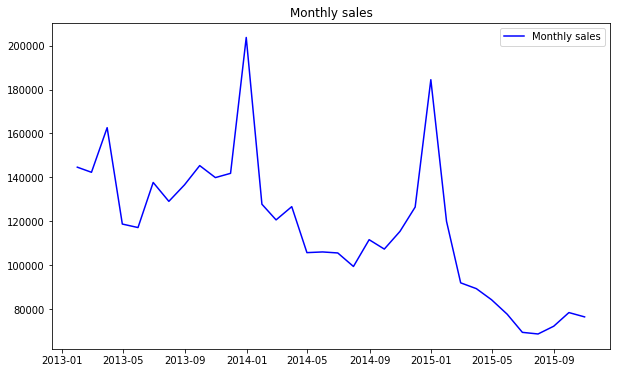

In [65]:
# resample the data on a monthly basis
x = df[["date", "item_cnt_day"]].set_index("date").resample("M").sum()

# plot the data using matplotlib
plt.figure(figsize = (10, 6))
plt.plot(x, color = "blue", label = "Monthly sales")
plt.title("Monthly sales")
plt.legend();

From our very first and simple figure, we can already extract very useful information.

First of all, we can see big spikes in January, like to be motivated with national holidays in Russia.
Second: we see a general trend to decline in our timeseries. If you are planning to use a parametrical model, you must take into account this.


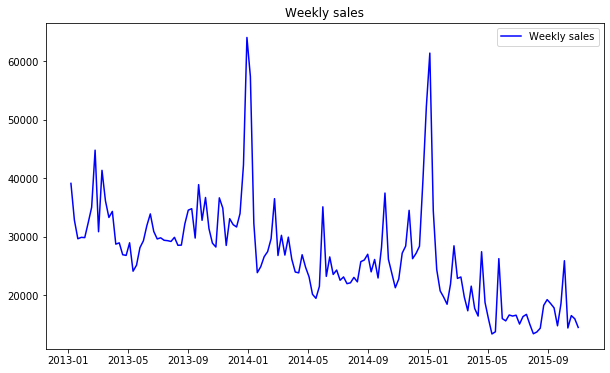

In [66]:
# perform the same operations but on a weekly basis
x = df[["date", "item_cnt_day"]].set_index("date").resample("W").sum()

plt.figure(figsize = (10, 6))
plt.plot(x.index, x, color = "blue", label = "Weekly sales")
plt.title("Weekly sales")
plt.legend();

Analyzing data on a weekly basis, gives us much more information. We can see more variation between weeks, but the main point stays the same: we have spines in January and sales that go down overtime.

In the next plots we will represent the monthly sales (left plot) and weekly sales (right plot) for each shop.

In the light red/pink areas of each plot, we will mark the national holidays in Russia and see if there is any connection with sales spikes.

In [67]:
russian_holidays_start = [
datetime.datetime(2013, 1, 1),
datetime.datetime(2013, 2, 23),
datetime.datetime(2013, 3, 8),
datetime.datetime(2013, 5, 1),
datetime.datetime(2013, 5, 9),
datetime.datetime(2013, 6, 12),
datetime.datetime(2013, 11, 4),

datetime.datetime(2014, 1, 1),
datetime.datetime(2014, 2, 23),
datetime.datetime(2014, 3, 8),
datetime.datetime(2014, 5, 1),
datetime.datetime(2014, 5, 9),
datetime.datetime(2014, 6, 12),
datetime.datetime(2014, 11, 4),

datetime.datetime(2015, 1, 1),
datetime.datetime(2015, 2, 23),
datetime.datetime(2015, 3, 8),
datetime.datetime(2015, 5, 1),
datetime.datetime(2015, 5, 9),
datetime.datetime(2015, 6, 12),
datetime.datetime(2015, 11, 4)
]

In [68]:
russian_holidays_end = [
datetime.datetime(2013, 1, 8),
datetime.datetime(2013, 2, 23),
datetime.datetime(2013, 3, 8),
datetime.datetime(2013, 5, 1),
datetime.datetime(2013, 5, 9),
datetime.datetime(2013, 6, 12),
datetime.datetime(2013, 11, 4),

datetime.datetime(2014, 1, 8),
datetime.datetime(2014, 2, 23),
datetime.datetime(2014, 3, 8),
datetime.datetime(2014, 5, 1),
datetime.datetime(2014, 5, 9),
datetime.datetime(2014, 6, 12),
datetime.datetime(2014, 11, 4),

datetime.datetime(2015, 1, 8),
datetime.datetime(2015, 2, 23),
datetime.datetime(2015, 3, 8),
datetime.datetime(2015, 5, 1),
datetime.datetime(2015, 5, 9),
datetime.datetime(2015, 6, 12),
datetime.datetime(2015, 11, 4)
]

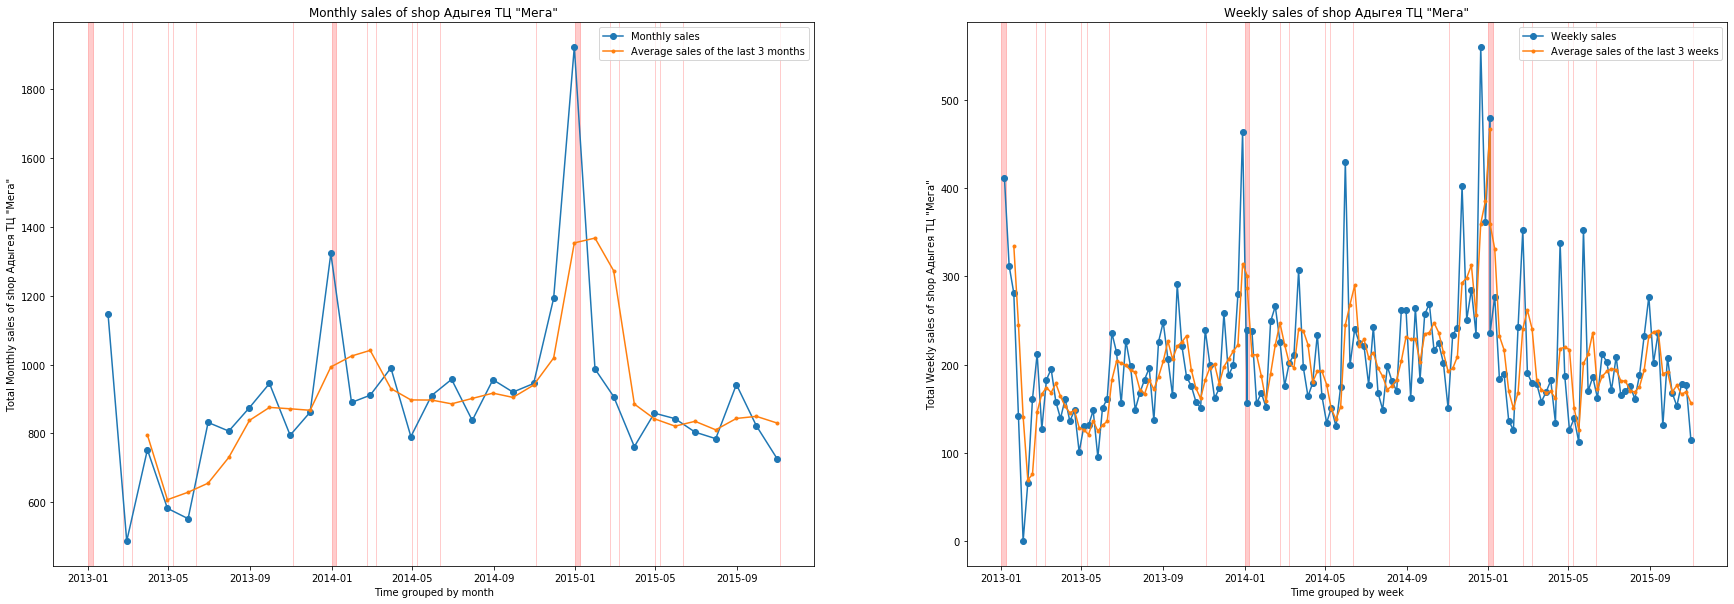

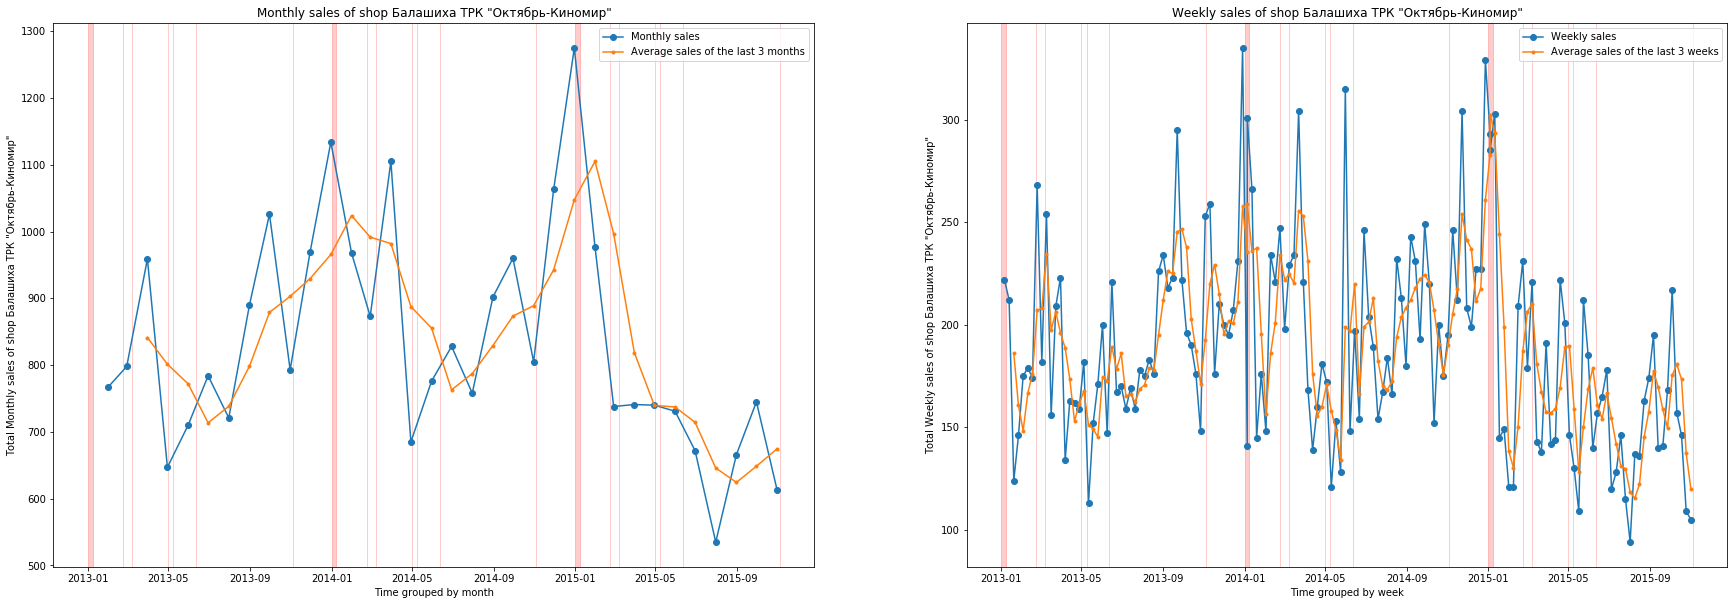

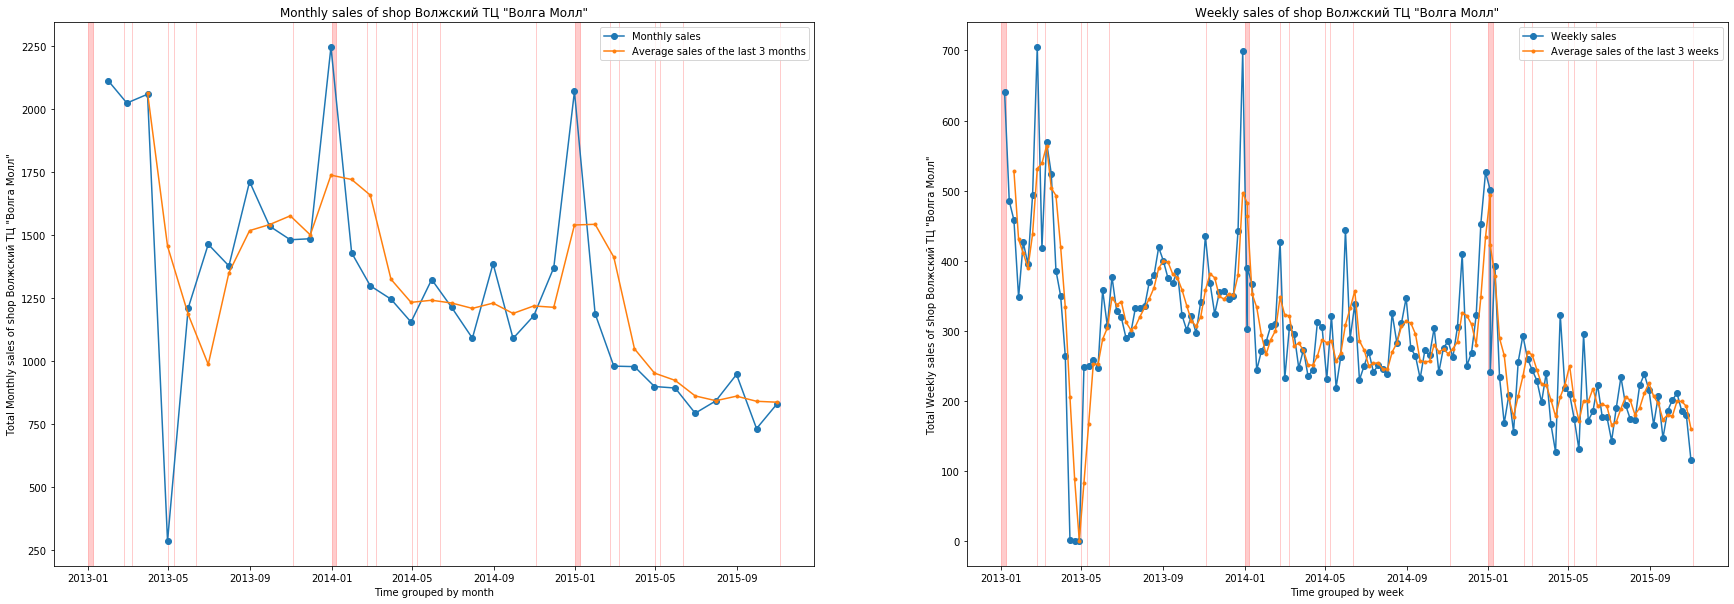

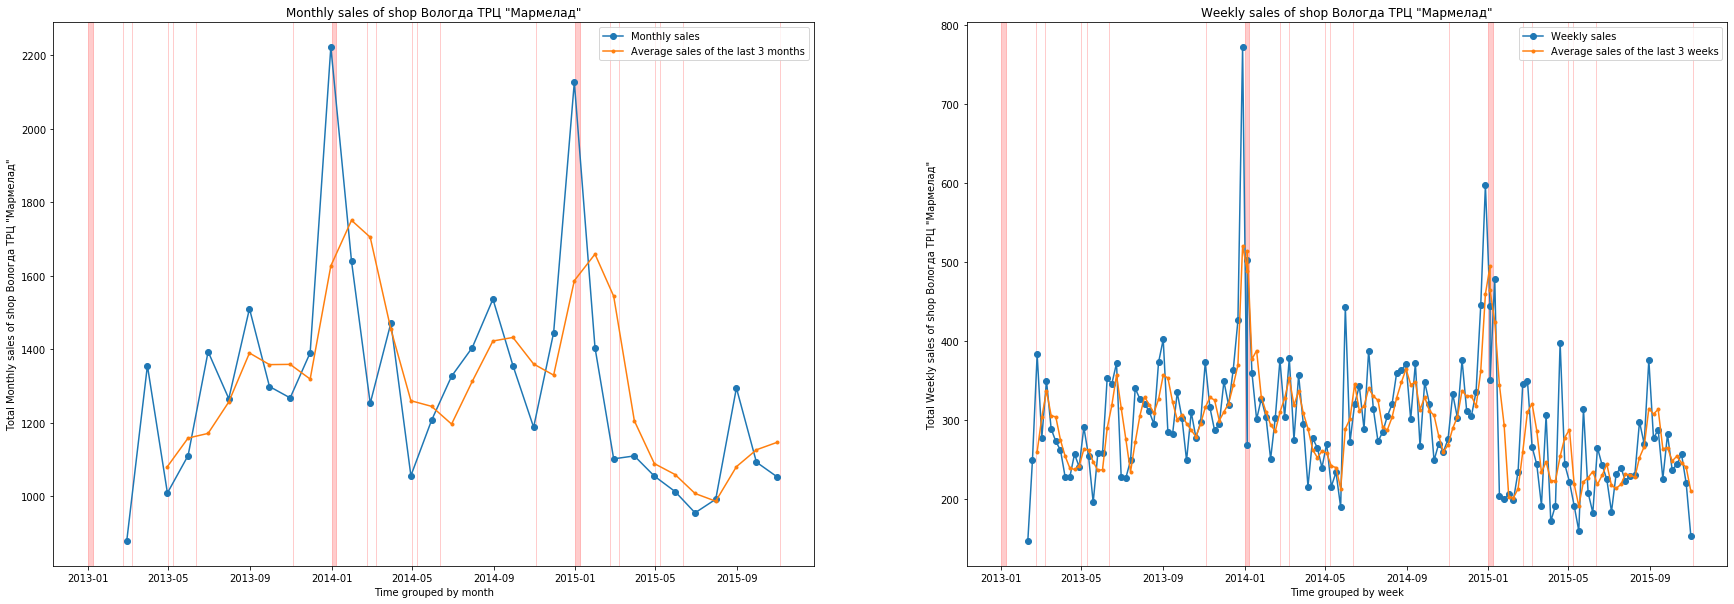

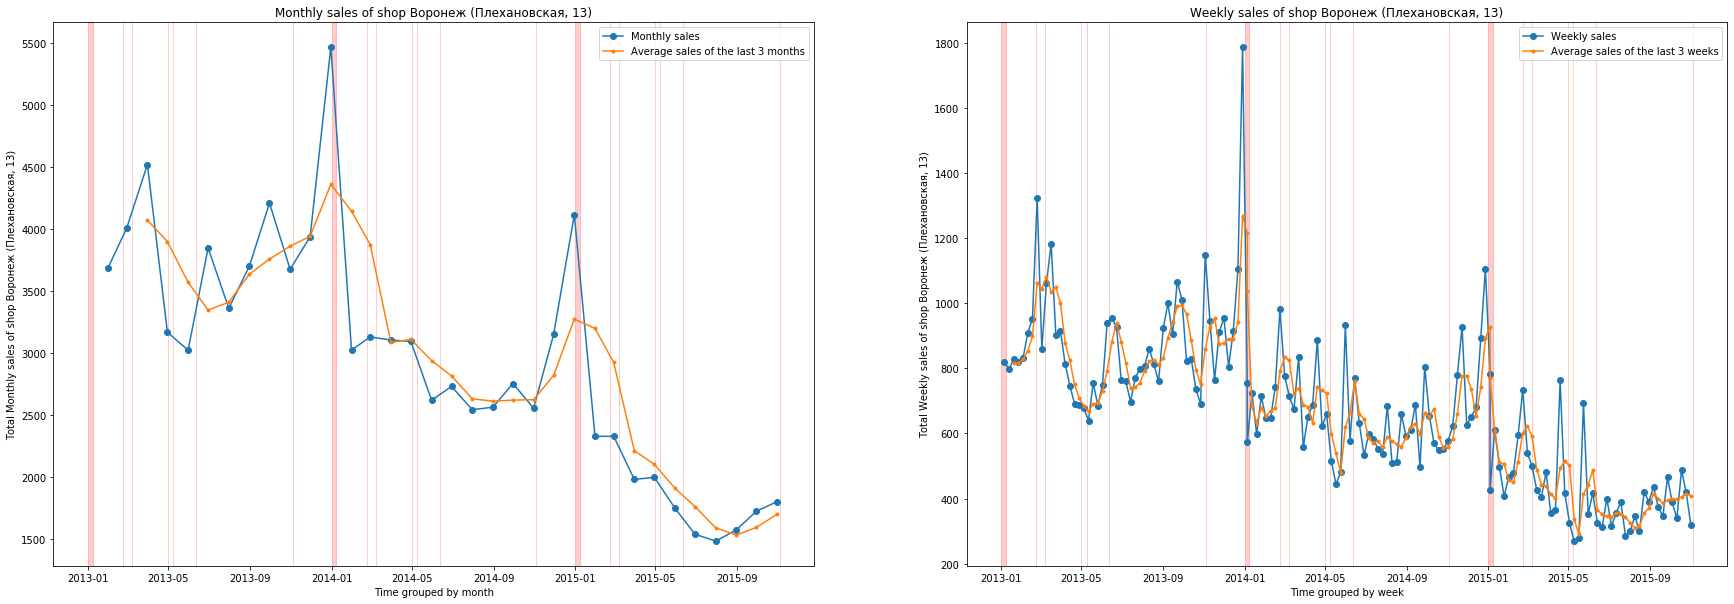

In [69]:
for iterable in sorted(list(df["shop_name"].unique())[:5]):

    # create the size of the figure
    plt.figure(figsize = (30, 10))

    # create the subplot for Monthly sales of the each shop
    plt.subplot(1, 2, 1)
    
    # calculate the Monthly sales of each shop
    short_df = df[df["shop_name"] == iterable][["date","item_cnt_day"]]
    short_df["date"] = pd.to_datetime(short_df["date"], format = "%d.%m.%Y")
    short_df["YEAR"] = short_df["date"].dt.year
    short_df = short_df.set_index("date").groupby("YEAR").resample("M")["item_cnt_day"].sum()
    short_df = short_df.reset_index()
    
    # adding moving average
    short_df["MA3M"] = short_df["item_cnt_day"].rolling(window = 3).mean()
    short_df["MA4M"] = short_df["item_cnt_day"].rolling(window = 4).mean()
    short_df["MA5M"] = short_df["item_cnt_day"].rolling(window = 5).mean()
    
    # assing the data to plot
    sales = short_df["item_cnt_day"]
    dates = short_df["date"]
    
    average_3_months = short_df["MA3M"]
    average_4_months = short_df["MA4M"]
    average_5_months = short_df["MA5M"]

    # plot the data and add label
    plt.plot(dates, sales, 'o-', label = "Monthly sales")
    
    plt.plot(dates, average_3_months, '.-', label = "Average sales of the last 3 months")

    # get current axis and plot the areas
    ax = plt.gca()
    alpha = 0.2
    
    for start_date, end_date in zip(russian_holidays_start, russian_holidays_end):
        
        # add shaded areas for holidays 2013
        ax.axvspan(start_date, end_date, alpha = alpha, color = 'red')    
       
    # add title and show legend    
    plt.title('Monthly sales of shop {}'.format(iterable))
    plt.ylabel('Total Monthly sales of shop {}'.format(iterable))
    plt.xlabel("Time grouped by month")
    plt.legend()
    
    #######################################################################################
    # Weekly sales
    #######################################################################################
    
    plt.subplot(1, 2, 2)
    
      # calculate the Weekly sales of each shop
    short_df = df[df["shop_name"] == iterable][["date","item_cnt_day"]]
    short_df["date"] = pd.to_datetime(short_df["date"], format = "%d.%m.%Y")
    short_df["YEAR"] = short_df["date"].dt.year
    short_df = short_df.set_index("date").groupby("YEAR").resample("W")["item_cnt_day"].sum()
    short_df = short_df.reset_index()
    
    # adding moving average
    short_df["MA3W"] = short_df["item_cnt_day"].rolling(window=3).mean()
    short_df["MA4W"] = short_df["item_cnt_day"].rolling(window=4).mean()
    short_df["MA5W"] = short_df["item_cnt_day"].rolling(window=5).mean()
    
    # assing the data to plot
    
    # general sales
    sales = short_df["item_cnt_day"]
    dates = short_df["date"]
    
    average_3_weeks = short_df["MA3W"]
    average_4_weeks = short_df["MA4W"]
    average_5_weeks = short_df["MA5W"]

    # plot the data and add label
    plt.plot(dates, sales, 'o-', label = "Weekly sales")
    plt.plot(dates, average_3_weeks, '.-', label = "Average sales of the last 3 weeks")
    
    # get current axis and plot the areas
    ax = plt.gca()
    
    for start_date, end_date in zip(russian_holidays_start, russian_holidays_end):
        
        # add shaded areas for holidays 2013
        ax.axvspan(start_date, end_date, alpha = alpha, color = 'red')
    
    # add title and show legend
    plt.title('Weekly sales of shop {}'.format(iterable))
    plt.ylabel('Total Weekly sales of shop {}'.format(iterable))
    plt.xlabel("Time grouped by week")
    plt.legend()
    
    # general sales
    plt.show()

In the next plots we will represent the monthly sales (left plot) and weekly sales (right plot) for each item category.

We will also plot the percentile 5 and 95 for each shop by year.

In the light red/pink areas of each plot, we will mark the national holidays in Russia and see if there is any connection with sales spikes.

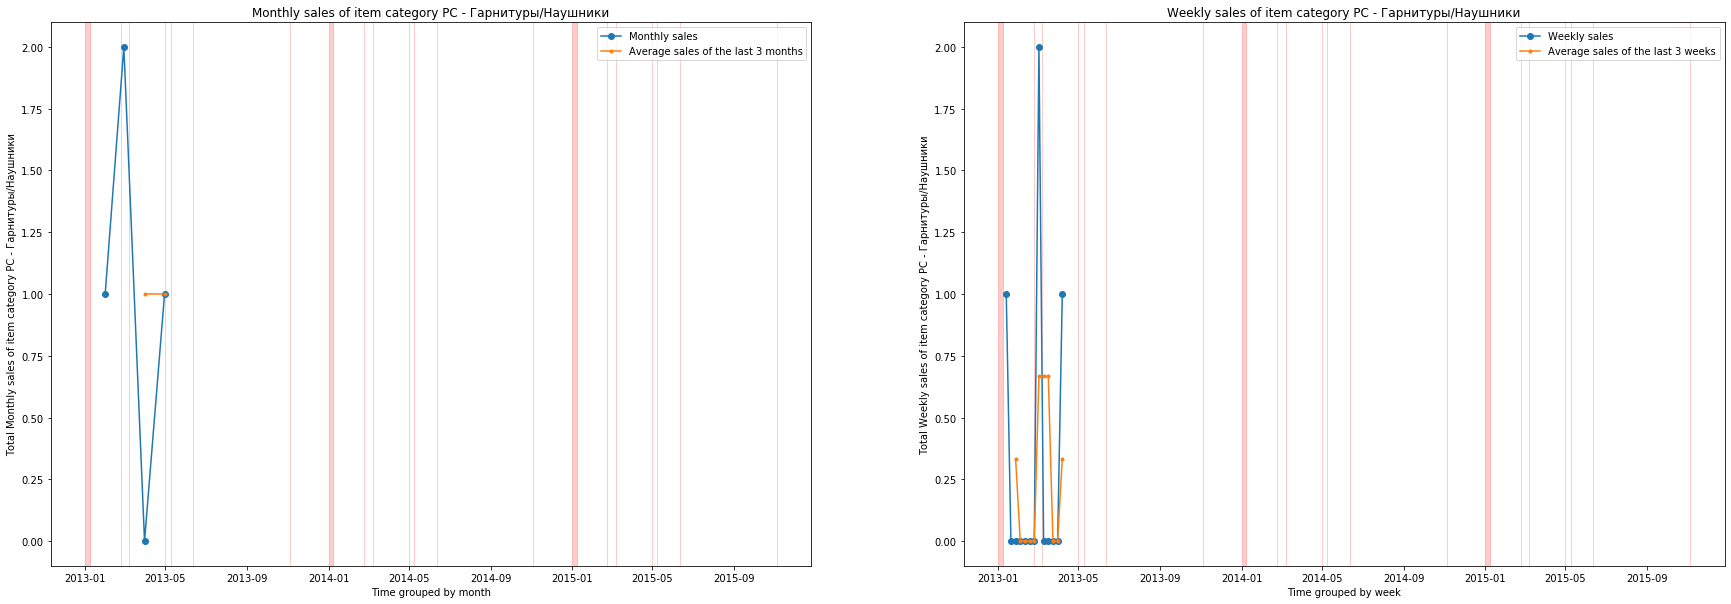

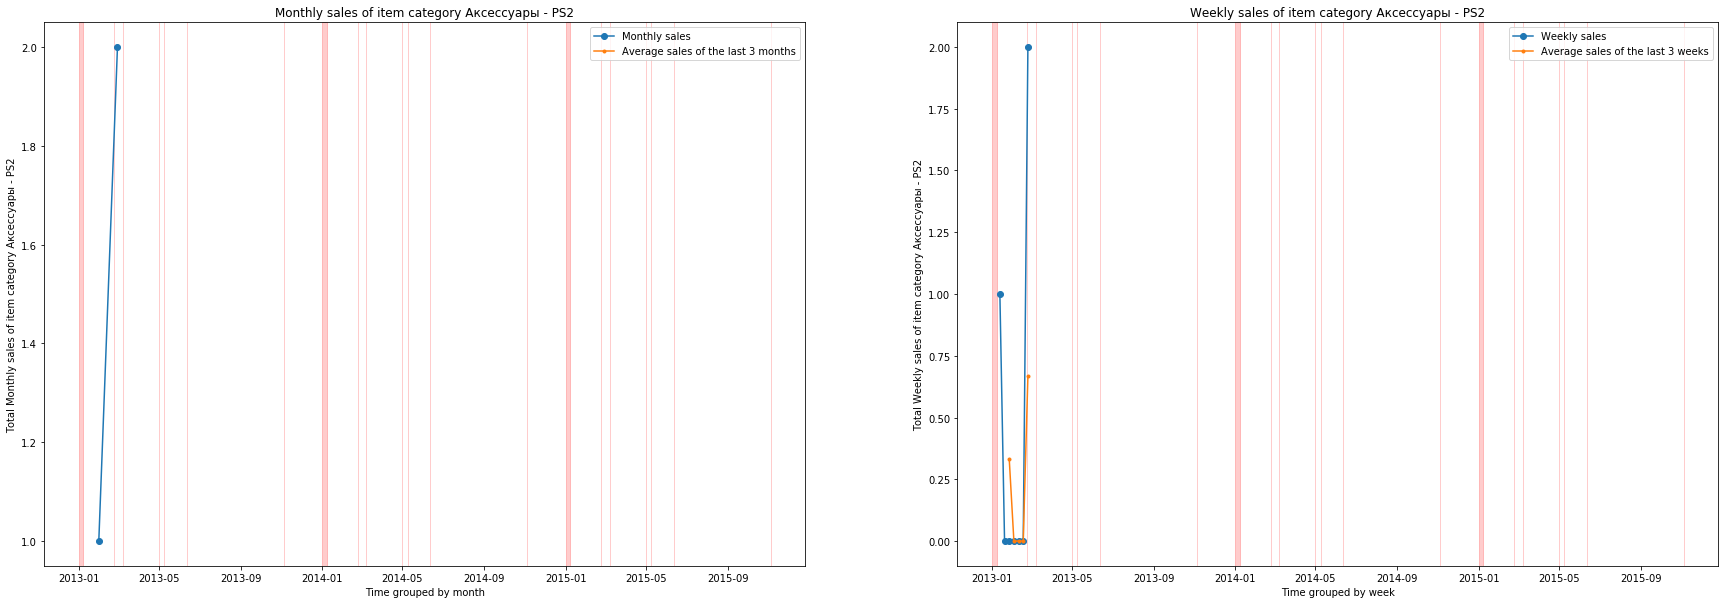

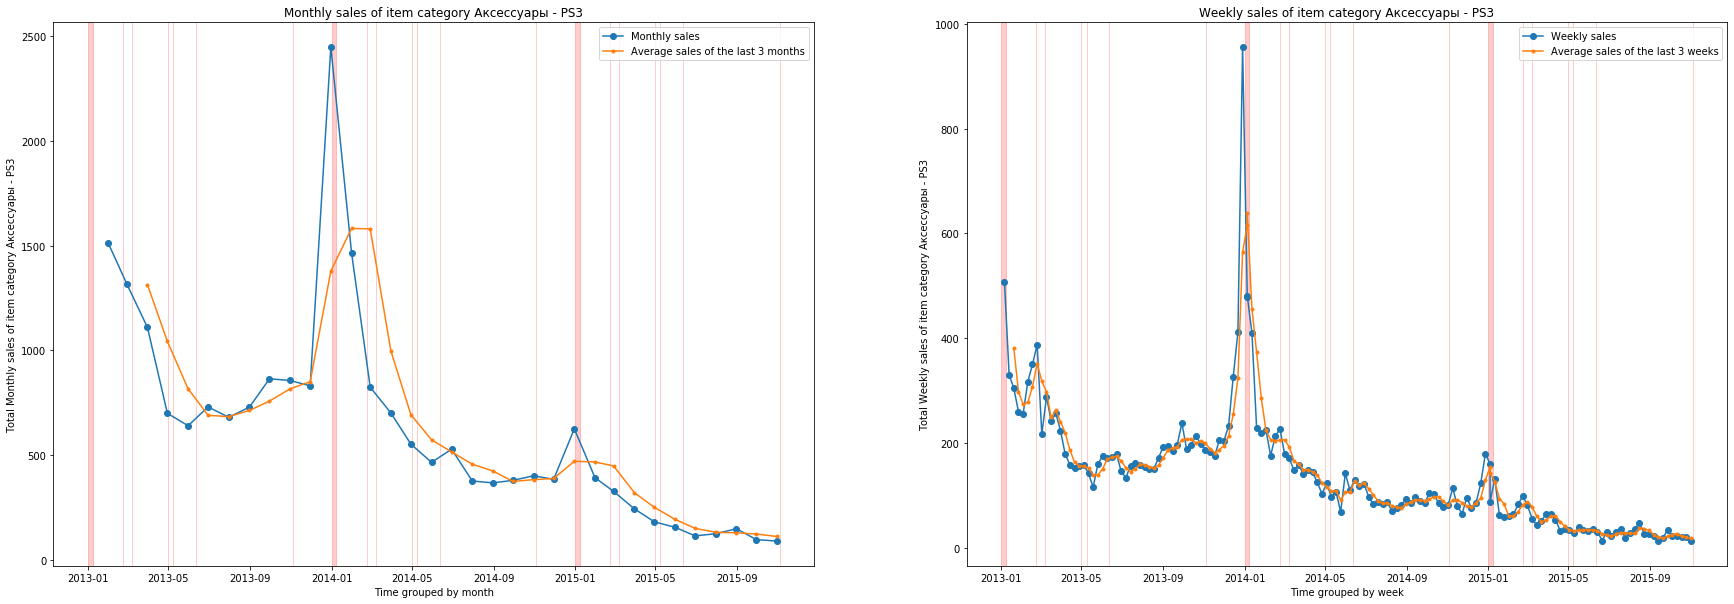

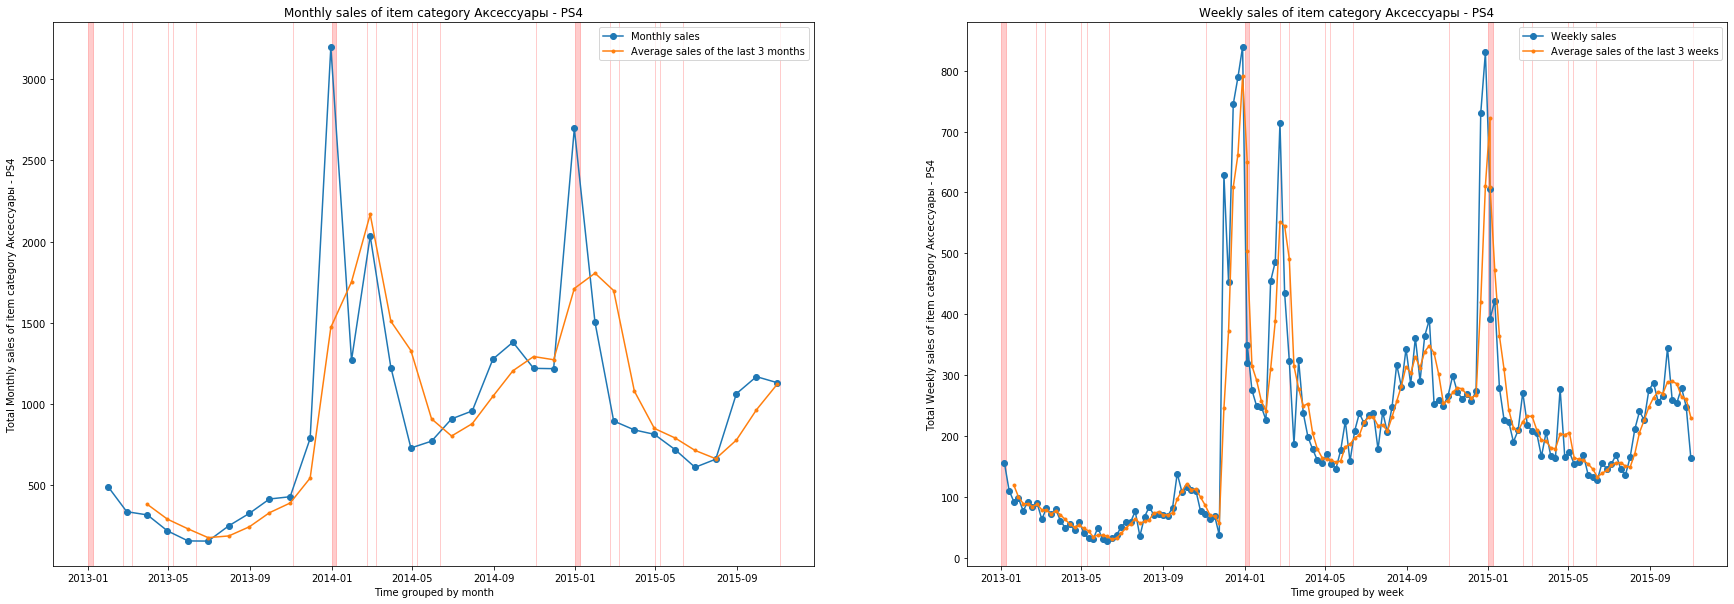

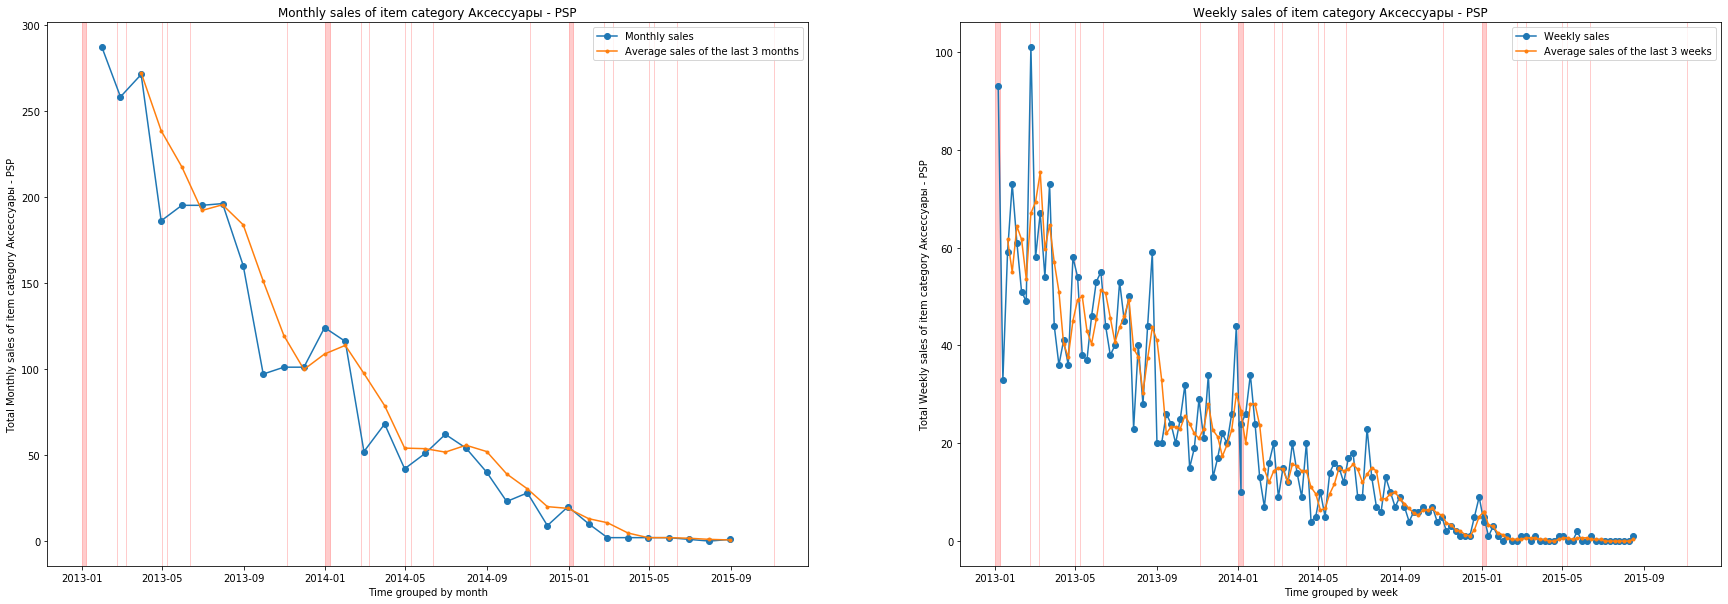

In [70]:
for iterable in sorted(list(df["item_category_name"].unique()))[:5]:

    # create the size of the figure
    plt.figure(figsize = (30, 10))

    # create the subplot for Monthly sales of the each shop
    plt.subplot(1, 2, 1)
    
    # calculate the Monthly sales of each shop
    short_df = df[df["item_category_name"] == iterable][["date","item_cnt_day"]]
    short_df["date"] = pd.to_datetime(short_df["date"], format = "%d.%m.%Y")
    short_df["YEAR"] = short_df["date"].dt.year
    short_df = short_df.set_index("date").groupby("YEAR").resample("M")["item_cnt_day"].sum()
    short_df = short_df.reset_index()
    
    # adding moving average
    short_df["MA3M"] = short_df["item_cnt_day"].rolling(window=3).mean()
    short_df["MA4M"] = short_df["item_cnt_day"].rolling(window=4).mean()
    short_df["MA5M"] = short_df["item_cnt_day"].rolling(window=5).mean()
    
    # assing the data to plot
    sales = short_df["item_cnt_day"]
    dates = short_df["date"]
    
    average_3_months = short_df["MA3M"]
    average_4_months = short_df["MA4M"]
    average_5_months = short_df["MA5M"]

    # plot the data and add label
    plt.plot(dates, sales, 'o-', label = "Monthly sales")
    
    plt.plot(dates, average_3_months, '.-', label = "Average sales of the last 3 months")

    # get current axis and plot the areas
    ax = plt.gca()
    alpha = 0.2
    
    for start_date, end_date in zip(russian_holidays_start, russian_holidays_end):
        
        # add shaded areas for holidays 2013
        ax.axvspan(start_date, end_date, alpha = alpha, color = 'red')   
    
    # add title and show legend
    plt.title('Monthly sales of item category {}'.format(iterable))
    plt.ylabel('Total Monthly sales of item category {}'.format(iterable))
    plt.xlabel("Time grouped by month")
    plt.legend()
    

    #######################################################################################
    # Weekly sales
    #######################################################################################
    
    plt.subplot(1, 2, 2)
    
      # calculate the Weekly sales of each shop
    short_df = df[df["item_category_name"] == iterable][["date","item_cnt_day"]]
    short_df["date"] = pd.to_datetime(short_df["date"], format = "%d.%m.%Y")
    short_df["YEAR"] = short_df["date"].dt.year
    short_df = short_df.set_index("date").groupby("YEAR").resample("W")["item_cnt_day"].sum()
    short_df = short_df.reset_index()
    
    # adding moving average
    short_df["MA3W"] = short_df["item_cnt_day"].rolling(window = 3).mean()
    short_df["MA4W"] = short_df["item_cnt_day"].rolling(window = 4).mean()
    short_df["MA5W"] = short_df["item_cnt_day"].rolling(window = 5).mean()
    
    # assing the data to plot
    
    # general sales
    sales = short_df["item_cnt_day"]
    dates = short_df["date"]
    
    average_3_weeks = short_df["MA3W"]
    average_4_weeks = short_df["MA4W"]
    average_5_weeks = short_df["MA5W"]

    # plot the data and add label
    plt.plot(dates, sales, 'o-', label = "Weekly sales")
    plt.plot(dates, average_3_weeks, '.-', label = "Average sales of the last 3 weeks")
    
    # get current axis and plot the areas
    ax = plt.gca()
    
    for start_date, end_date in zip(russian_holidays_start, russian_holidays_end):
        
        # add shaded areas for holidays 2013
        ax.axvspan(start_date, end_date, alpha = alpha, color = 'red')
        
    # add title and show legend
    plt.title('Weekly sales of item category {}'.format(iterable))
    plt.ylabel('Total Weekly sales of item category {}'.format(iterable))
    plt.xlabel("Time grouped by week")
    plt.legend()
    # general sales
    plt.show()

# Total sales and the variation on secondary axis

In [71]:
# we can observe a general trend of decrasing sales.
# let's add a second axis to see the variation of intradays sales

# select the columns of interest
df_var = df[["date", "item_cnt_day"]]

# convert to datetime
df_var["date"] = pd.to_datetime(df["date"], format = "%d.%m.%Y")

# set date as index
df_var.set_index("date", inplace = True)

# resample/groupby by date and convert to frame the total daily sales
df_var = df_var.resample("M")["item_cnt_day"].sum().to_frame()

# calculate the intra week variation between total sales
df_var["Variation"] = df_var["item_cnt_day"].diff()/df_var["item_cnt_day"].shift(1)

df_var.head()

,item_cnt_day,Variation
date,,
2013-01-31,144655.0,NaN
2013-02-28,142330.0,-0.016073
2013-03-31,162650.0,0.142767
2013-04-30,118755.0,-0.269874
2013-05-31,117161.0,-0.013423


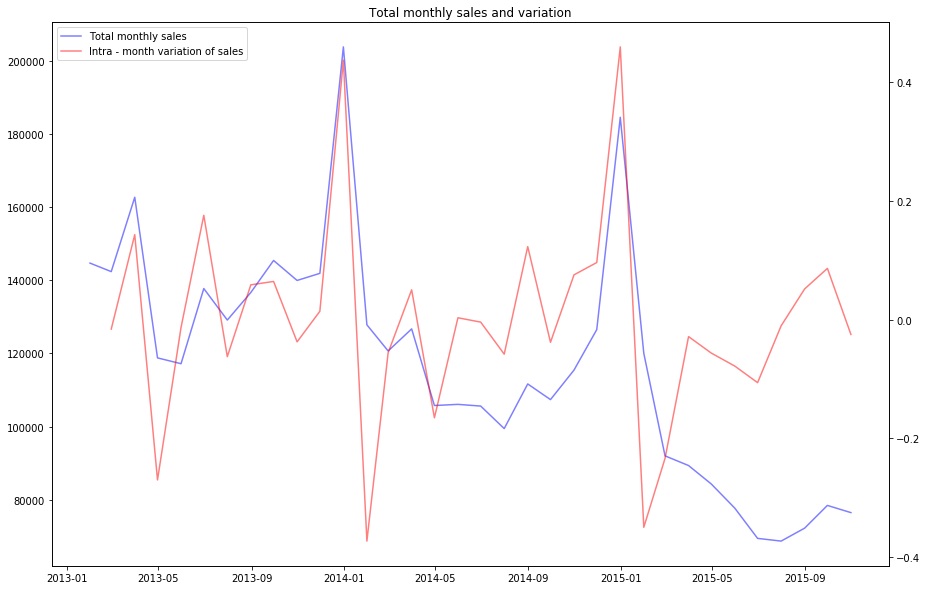

In [72]:
# separate x and y
y_sales = df_var["item_cnt_day"]
y_variation = df_var["Variation"]

# instanciate the figure
fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(111)

# plot the total sales
plot1 = ax.plot(y_sales, label = "Total monthly sales", color = "blue", alpha = 0.5)

# create a secondary axis and plot the variation data
ax_bis = ax.twinx()
plot2 = ax_bis.plot(y_variation, label = "Intra - month variation of sales", color = "red", alpha = 0.5)

# create a common legend for both plots
lns = plot1 + plot2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc = "upper left")

# add a custom title to the plot
ax.set_title("Total monthly sales and variation");

# Calendar heatmap

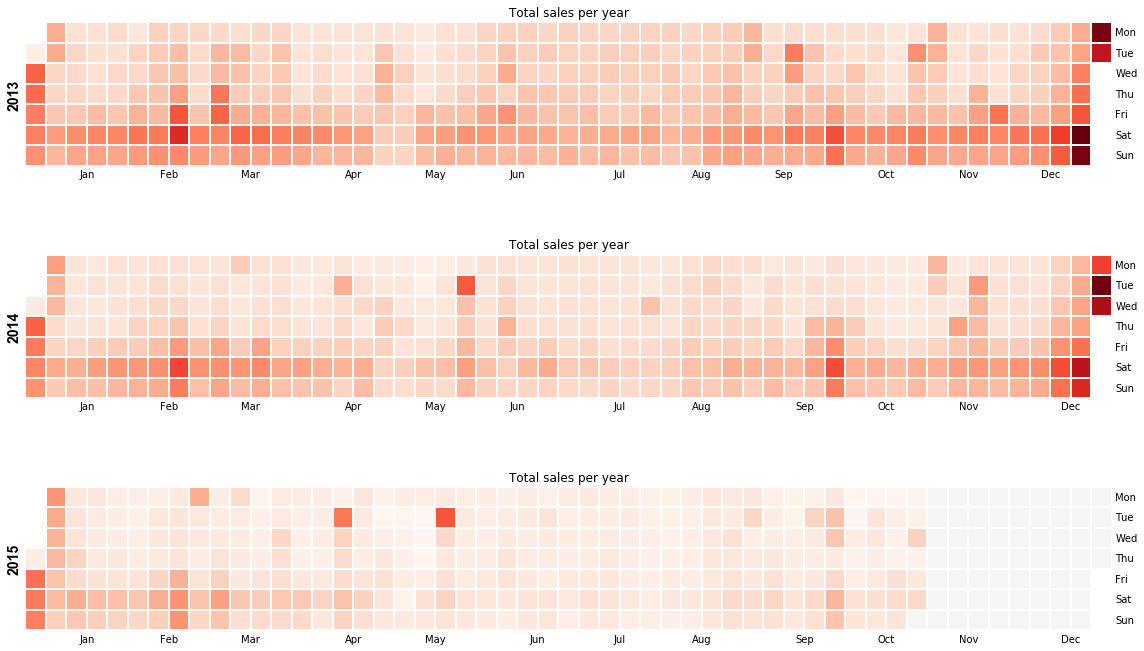

In [74]:
# calendar heatmaps are really useful to see the overall activity for a certain period of time per day and per month.
# let's build one using python.
# we will be using the calmap package for this, because it makes it extremenly easy to plot this data
# select the columns
df_calendar = df[["date", "item_cnt_day"]]

# set date as index and resample
df_calendar.set_index("date", inplace = True)
# notice that this time, we don't convert it to_frame()
# df_calendar is a pandas series
# THIS IS IMPORTANT since calmap expects a series
# with a datetime index and the values to plot
df_calendar = df_calendar.resample("D")["item_cnt_day"].sum()

# ----------------------------------------------------------------------------------------------------
# plot the data using calmap
calmap.calendarplot(df_calendar, # pass the series
                    fig_kws = {'figsize': (16,10)}, 
                    yearlabel_kws = {'color':'black', 'fontsize':14}, 
                    subplot_kws = {'title':'Total sales per year'}
                   );

# Timeseries autocorrelation and partial autocorrelation plots: daily sales

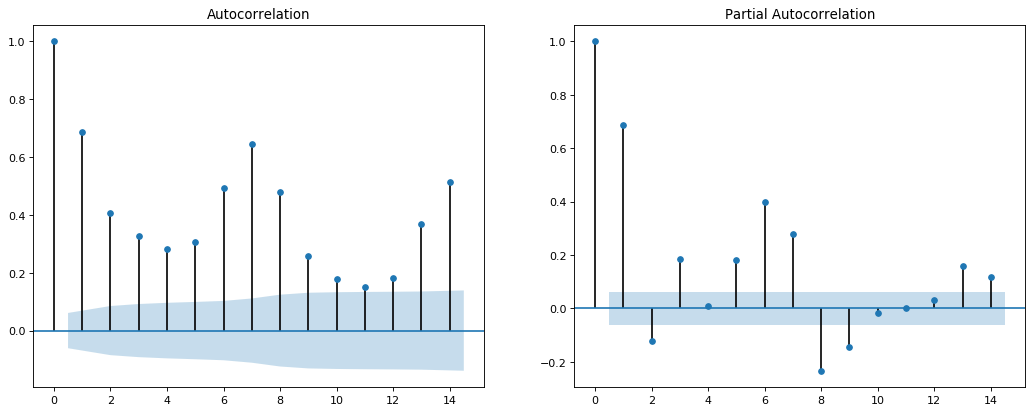

In [75]:
# This plot are fundamental in timeseries analysis.
# Basically here we compare the a series again itself but with some lags.
# These are plots that graphically summarize the strength of a relationship with an observation in a time series with observations at prior time steps.

# More info: 
# https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/

# ----------------------------------------------------------------------------------------------------
# instanciate the figure
fig, (ax1, ax2) = plt.subplots(1, 2,figsize = (16,6), dpi = 80)

# ----------------------------------------------------------------------------------------------------
# plot the data using the built in plots from the stats module

# The AutoCorrelation plot: compares a value v with the value v but n times in the past.
plot_acf(df.set_index("date").resample("D")["item_cnt_day"].sum(), ax = ax1, lags = 14)

# The Parcial AutoCorrelation plot: partial autocorrelation at lag k is the correlation that results after removing the effect of any correlations due to the terms at shorter lags.
plot_pacf(df.set_index("date").resample("D")["item_cnt_day"].sum(), ax = ax2, lags = 14);

# Timeseries decomposition plots: weekly sales

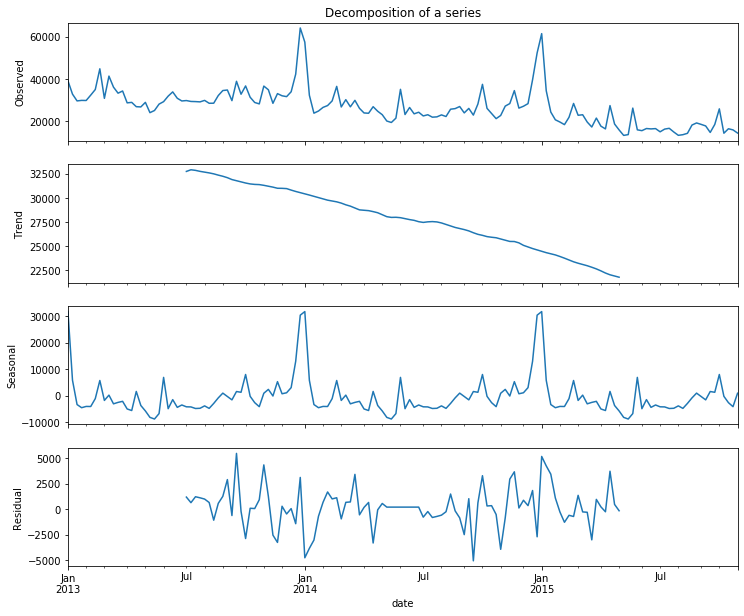

In [76]:
df_timeindex = df.set_index("date").resample("W")["item_cnt_day"].sum().to_frame()

# decompose the series using stats module
# results in this case is a special class 
# whose attributes we can acess
result = seasonal_decompose(df_timeindex["item_cnt_day"])

# ----------------------------------------------------------------------------------------------------
# instanciate the figure
# make the subplots share teh x axis
fig, axes = plt.subplots(ncols = 1, nrows = 4, sharex = True, figsize = (12,10))

# ----------------------------------------------------------------------------------------------------
# plot the data
# using this cool thread:
# https://stackoverflow.com/questions/45184055/how-to-plot-multiple-seasonal-decompose-plots-in-one-figure
# This allows us to have more control over the plots

# plot the original data
result.observed.plot(ax = axes[0], legend = False)
axes[0].set_ylabel('Observed')
axes[0].set_title("Decomposition of a series")

# plot the trend
result.trend.plot(ax = axes[1], legend = False)
axes[1].set_ylabel('Trend')

# plot the seasonal part
result.seasonal.plot(ax = axes[2], legend = False)
axes[2].set_ylabel('Seasonal')

# plot the residual
result.resid.plot(ax = axes[3], legend = False)
axes[3].set_ylabel('Residual')

# ----------------------------------------------------------------------------------------------------
# prettify the plot

# get the xticks and the xticks labels
xtick_location = df_timeindex.index.tolist()

# set x_ticks
ax.set_xticks(xtick_location);

# Visualizing the most important cities

Treemaps are a very useful and visual tools to see different categories and their overall importance in a dataset. Also, they are very cool and easy to make using Python and squarify.

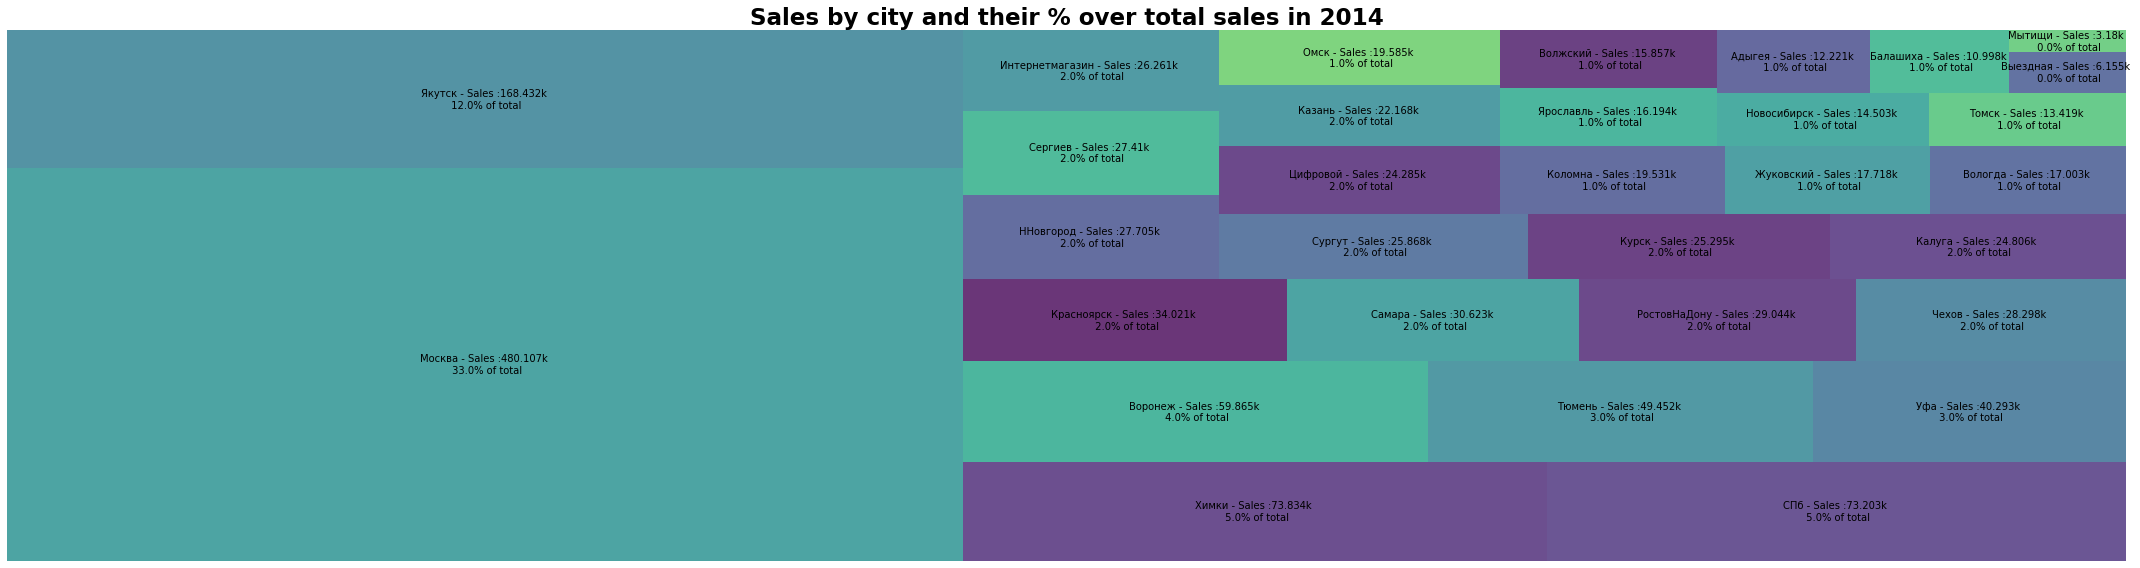

In [77]:
# prepare the data

# extract each year using dt.year
df["YEAR"] = df["date"].dt.year

# create a smaller df for year 2013
short_df = df[df["YEAR"] == 2013][["item_cnt_day", "city"]]

# groupby by city and sum all the sales
short_df = short_df.groupby("city")["item_cnt_day"].sum().to_frame()

# sort the values in the smaller df inplace
short_df.sort_values("item_cnt_day", ascending = False, inplace = True)

# we will do the same plot as before but without custom colors
# Moscow is a big outlier so it pales the rest of the cities

short_df = df[df["YEAR"] == 2014][["item_cnt_day", "city"]]
short_df = short_df.groupby("city")["item_cnt_day"].sum().to_frame()
short_df.sort_values("item_cnt_day", ascending = False, inplace = True)

my_values = short_df["item_cnt_day"]
my_pct = short_df["item_cnt_day"]/short_df["item_cnt_day"].sum()
labels = ['{} - Sales :{}k \n {}% of total'.format(city, sales/1000, round(pct, 2)*100) for city, sales, pct in zip(short_df.index, my_values, my_pct)]

plt.figure(figsize = (30, 8))
squarify.plot(sizes = my_values, label = labels,  alpha = 0.8)
plt.title("Sales by city and their % over total sales in 2014",fontsize = 23, fontweight = "bold")

plt.axis('off')
plt.tight_layout()

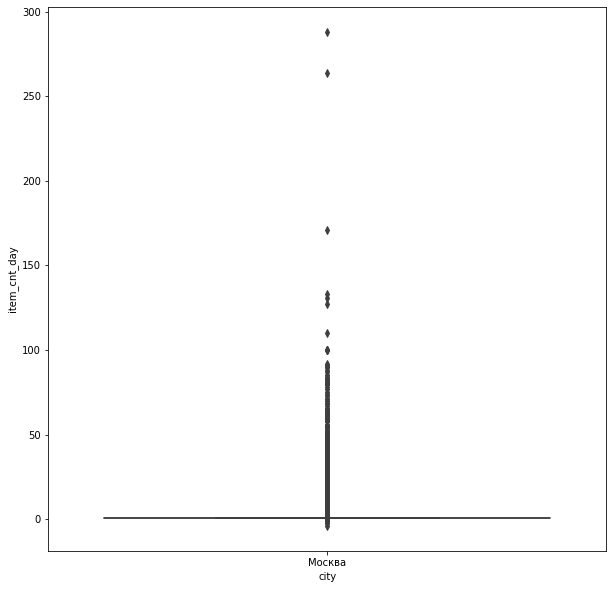

In [78]:
# treemaps are very useful to see the difference and the weights of categories
# but they don't give us that much of information about the distribution of each category
# let's use boxplot to see the distribution of Moscow city

# we can see huge outliers for Moscow city.
plt.figure(figsize = (10, 10))
sns.boxplot(x = "city",
            y = "item_cnt_day", 
            data = df[(df["YEAR"] == 2013) & (df["city_id"] == 13)]
           );

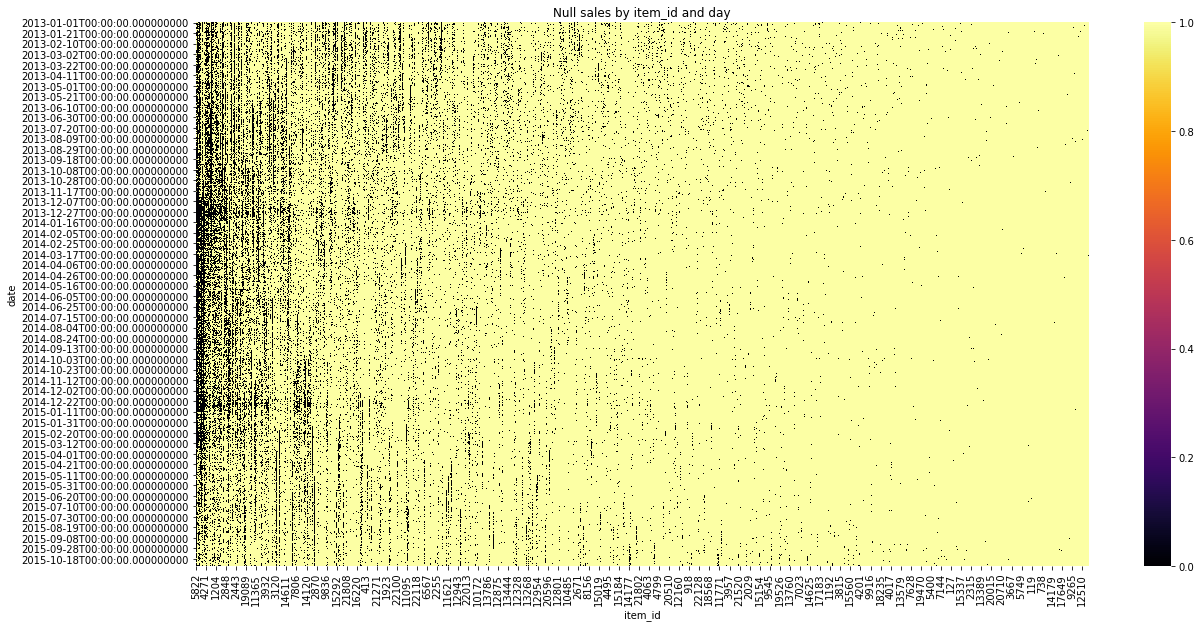

In [79]:
# This plot will help us visualize the missing values for each datetime and item_id
# This is the most granular plots possible, since we will be seeing individual sales by day and item_id
# This plot can be very consufing, but the main point is to show all the "missing values" we have
# We have seen previously in our EDA, that when we groupby and resamples our sales, we might think
# that we don't have any missing values. But its not true, we only have the reported sales
# This means that, if we have a shop or item_id that only had 3 sales per year, when we resample
# our df by day, pandas will generate additional days with null sales.
# those null sales is what we want to plot here
# the values are ordered from less nulls to more nulls

gb_df_ = df.pivot_table(index = ["date"], columns = ['item_id'], values = "item_cnt_day", aggfunc = sum).isnull()
order_of_columns = list(gb_df_.sum().sort_values().index)
gb_df_ = gb_df_[order_of_columns]
plt.figure(figsize = (20, 10))
plot = sns.heatmap(gb_df_, cbar = True, cmap = "inferno")
plot.set_title("Null sales by item_id and day");

In [85]:
gc.collect()
del gb_df_

In [86]:
# create a smaller df
short_df = df[["date", "item_cnt_day", "shop_name"]]
# set the date to be the index (to resample later)
short_df.set_index("date", inplace = True)
# groupby by shop_name
gb = short_df.groupby("shop_name")
# resample the df by month sales (resample = groupby by months in timeseries)
gbr = gb.resample("M")["item_cnt_day"].sum()
# unstack the gbr to have columns name
gbr = gbr.unstack(level = -1).T
# sort the values, from no nulls to more null values
order_of_columns = list(gbr.isnull().sum().sort_values().index)
# change the order of the df
gbr = gbr[order_of_columns]

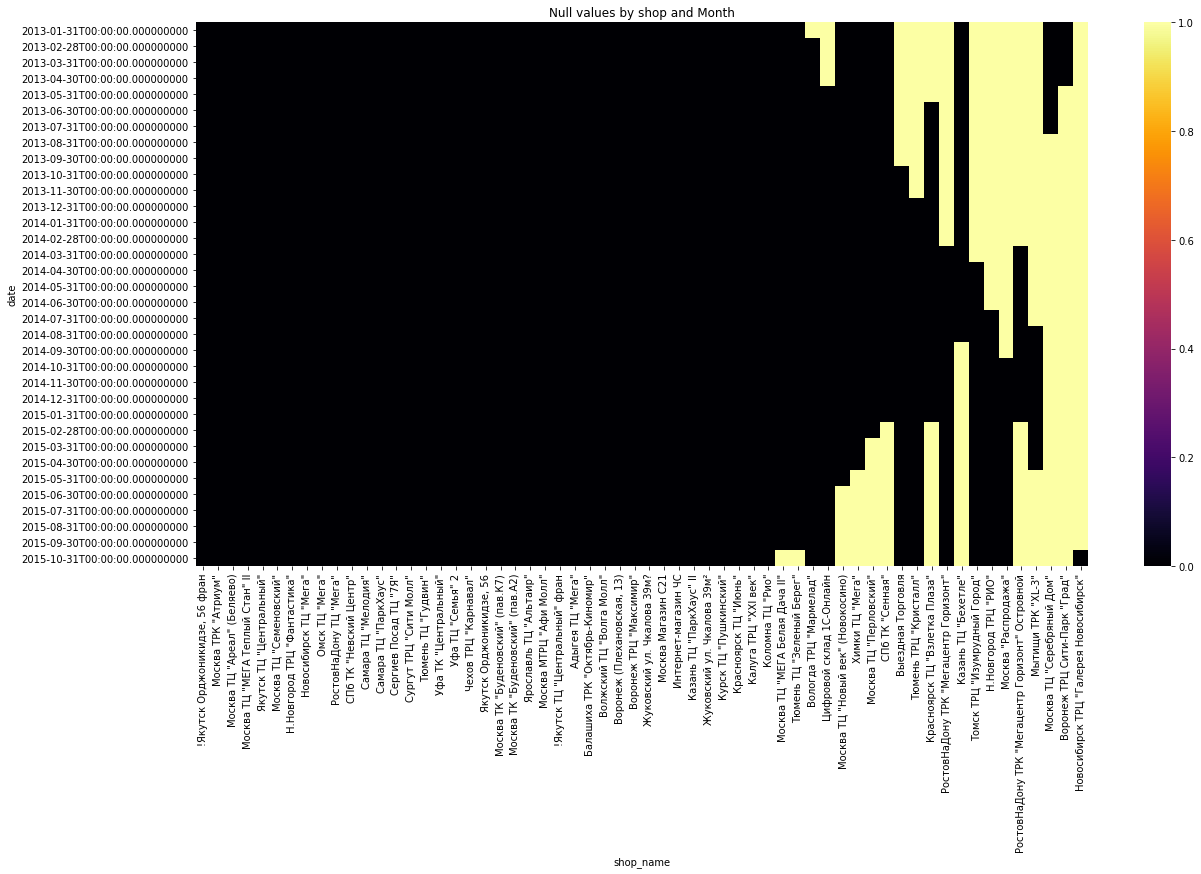

In [87]:
# let's plot the null values for each shop
plt.figure(figsize=(20, 10))
# this lines gbr.unstack(level = -1).T.isnull()*1
# converts any null to 1 and the rest will be 0
sns.heatmap(gbr.isnull()*1, cmap = "inferno", cbar = True).set_title("Null values by shop and Month");

In [88]:
# create a smaller df
short_df = df[["date", "item_cnt_day", "item_category_name"]]

# set the date to be the index (to resample later)
short_df.set_index("date", inplace = True)

# groupby by shop_name
gb = short_df.groupby("item_category_name")

# resample the df by month sales (resample = groupby by months in timeseries)
gbr = gb.resample("M")["item_cnt_day"].sum()

# unstack the gbr to have columns name
gbr = gbr.unstack(level = -1).T

# sort the values, from no nulls to more null values
order_of_columns = list(gbr.isnull().sum().sort_values().index)

# change the order of the df
gbr = gbr[order_of_columns]

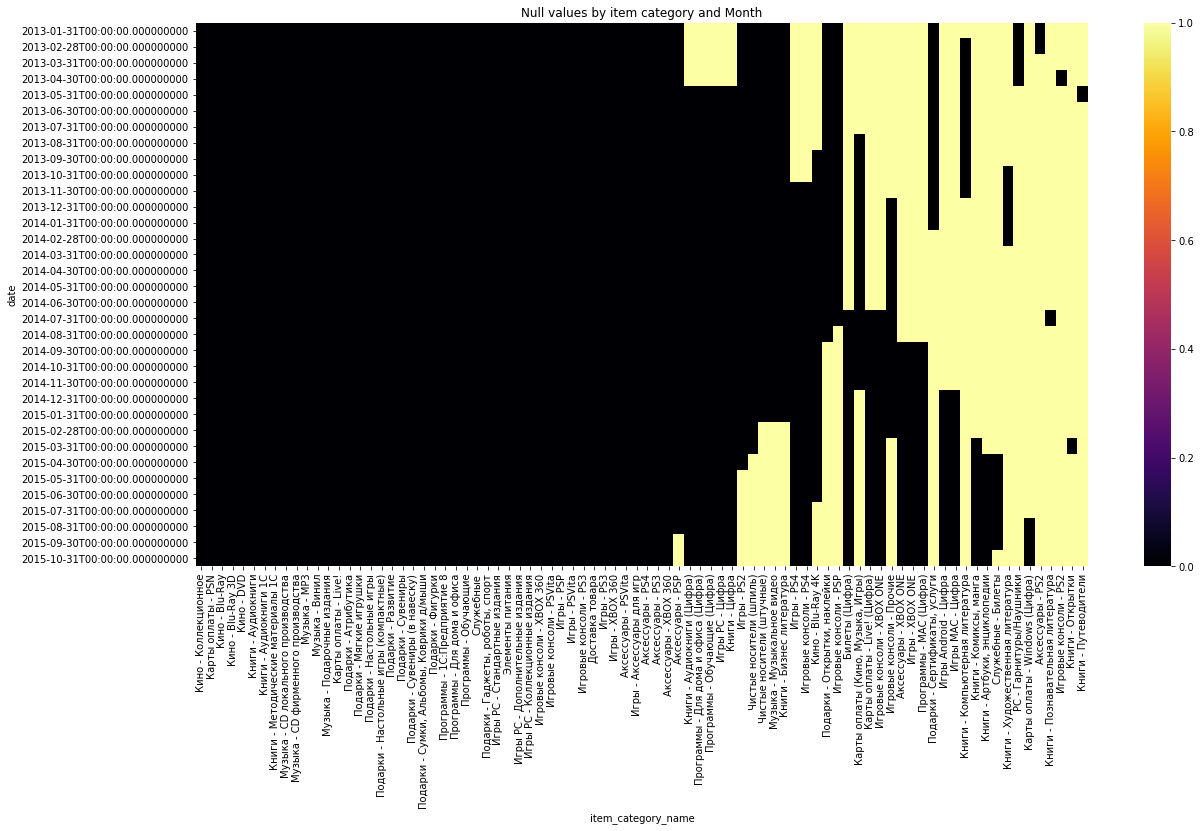

In [89]:
# let's plot the null values for each shop
plt.figure(figsize=(20, 10))

# this lines gbr.unstack(level = -1).T.isnull()*1
# converts any null to 1 and the rest will be 0
sns.heatmap(gbr.isnull()*1, cmap = "inferno", cbar = True).set_title("Null values by item category and Month");

# Visualization of outliers

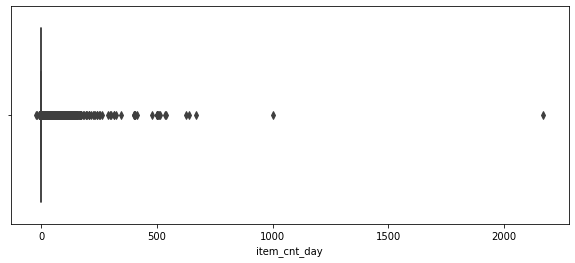

In [90]:
# let's look at outliers for item sales
# We will use boxplots because they are very useful to see the distribution of values
plt.figure(figsize = (10,4))
sns.boxplot(x = df["item_cnt_day"]);

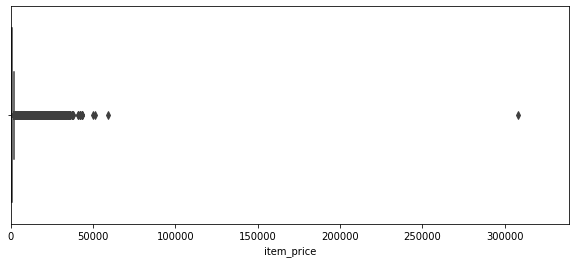

In [91]:
# let's look at outliers for item price
plt.figure(figsize = (10,4))
plt.xlim(df["item_price"].min(), df["item_price"].max()*1.1)
sns.boxplot(x = df["item_price"]);

<Figure size 720x288 with 0 Axes>

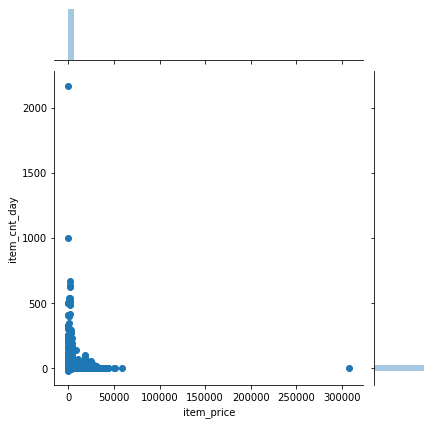

In [92]:
# joint plot is another very convenient way to plot the relationship between 2 variables
# but because we have huge outliers, we don't see them 
# https://seaborn.pydata.org/generated/seaborn.jointplot.html
plt.figure(figsize = (10,4))
sns.jointplot(x = "item_price", y = "item_cnt_day", data = df);

In [93]:
# let's filter the outliers and make the same joint plot
df = df[(df["item_price"] < np.percentile(df["item_price"], q = 99)) & (df["item_cnt_day"] >= 0) & (df["item_cnt_day"] < np.percentile(df["item_cnt_day"], q = 99))]

<Figure size 720x720 with 0 Axes>

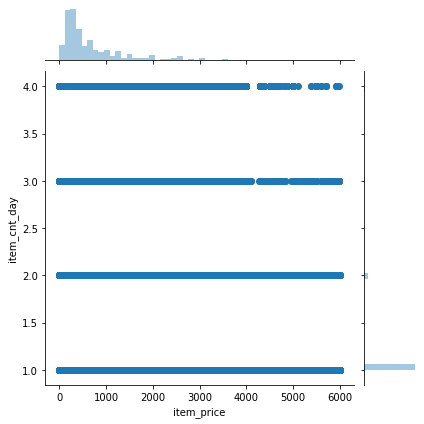

In [94]:
# we have removed the outliers and now 
plt.figure(figsize = (10, 10))
sns.jointplot(x = "item_price", y = "item_cnt_day", data = df);

# Conclusions

After taking a look at the sales data, here are some conclusion we can extract:

We see that the total sales decrease over time. This is very important because, we have to create features for our model that catch this trend.

We have seen that the sales present huge spikes in Christmas season. Datetime features can help a lot our model.

Data has a lot of missing values and we have not found a specific or category affected by this. More likely it's just the nature of the data.

Top 3 cities capture more than 50% of total sales. City based features can be very helpful for the model.

The top 3 categories represent more than 40% of total sales: they are Movies, PC Games and Music.

Data presents outliers at the sales and price level. Before generating features or training a model, data must be cleaned properly.

We have seen thanks to our calendar plots that we a small increase in sales on the weekends. We do see however bigger sales on 14 of February or 9 of May (holidays).

(array([1894925.,  637589.,  267276.,  132072.,  114999.,   65279.,
          14977.,    7761.,    4711.,    2529.]),
 array([-1.00000e+00,  5.98990e+02,  1.19898e+03,  1.79897e+03,
         2.39896e+03,  2.99895e+03,  3.59894e+03,  4.19893e+03,
         4.79892e+03,  5.39891e+03,  5.99890e+03]),
 <a list of 10 Patch objects>)

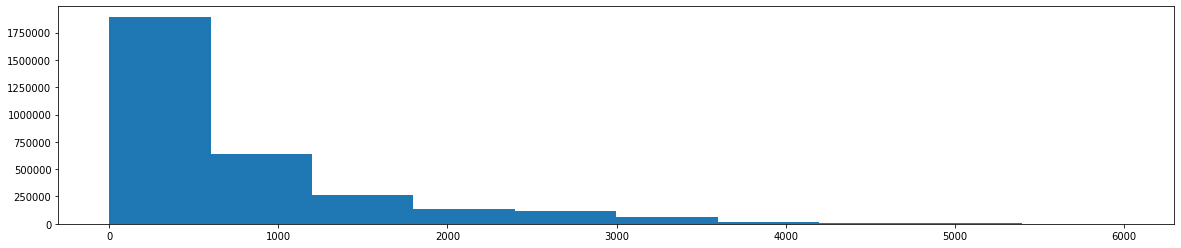

In [101]:
plt.figure(figsize = (20,4))
plt.hist(df["item_price"])

In [105]:
df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name,shop_name_cleaned,city,city_id,Year,Month,YEAR
3045906,2013-01-01,0,2,2920,599.0,2.0,Disney. LEGO Пираты Карибского моря (Essential...,21,Игры - PSP,"Адыгея ТЦ ""Мега""",Адыгея ТЦ Мега,Адыгея,0,2013,1,2013
3046804,2013-01-01,0,2,1472,2599.0,1.0,"Assassin's Creed 3 [Xbox 360, русская версия]",23,Игры - XBOX 360,"Адыгея ТЦ ""Мега""",Адыгея ТЦ Мега,Адыгея,0,2013,1,2013
3047235,2013-01-01,0,2,1905,249.0,1.0,"Bestseller. Grand Theft Auto: San Andreas [PC,...",30,Игры PC - Стандартные издания,"Адыгея ТЦ ""Мега""",Адыгея ТЦ Мега,Адыгея,0,2013,1,2013
3047928,2013-01-01,0,2,5649,2190.0,1.0,PS3: Файтстик Hori Mini 3,2,Аксессуары - PS3,"Адыгея ТЦ ""Мега""",Адыгея ТЦ Мега,Адыгея,0,2013,1,2013
3048822,2013-01-01,0,2,3320,1999.0,1.0,"FIFA 13 (с поддержкой PS Move) [PS3, русская в...",19,Игры - PS3,"Адыгея ТЦ ""Мега""",Адыгея ТЦ Мега,Адыгея,0,2013,1,2013


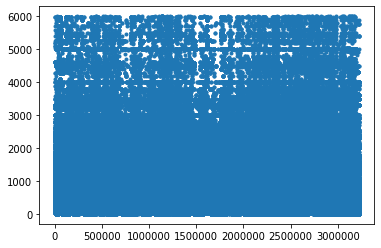

In [103]:
plt.plot(df["item_price"],'.')

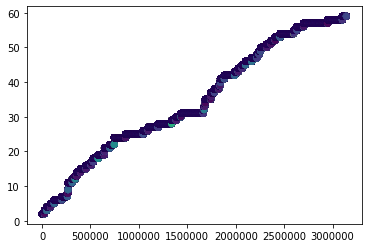

In [106]:
plt.scatter(range(len(df["shop_id"])),df["shop_id"],c=df["item_price"])

In [22]:
df.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,city_id
count,3.222144e+06,3.222144e+06,3.222144e+06,3.222144e+06,3.222144e+06,3.222144e+06,3.222144e+06
mean,1.452038e+01,3.451454e+01,1.022778e+04,8.850949e+02,1.236987e+00,3.999375e+01,1.685639e+01
std,9.426899e+00,1.665900e+01,6.325969e+03,1.724367e+03,2.526733e+00,1.705229e+01,7.928896e+00
min,0.000000e+00,2.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01,0.000000e+00,0.000000e+00
25%,6.000000e+00,2.400000e+01,4.478000e+03,2.490000e+02,1.000000e+00,2.800000e+01,1.300000e+01
50%,1.400000e+01,3.100000e+01,9.396000e+03,3.990000e+02,1.000000e+00,4.000000e+01,1.300000e+01
75%,2.300000e+01,5.100000e+01,1.572100e+04,9.990000e+02,1.000000e+00,5.500000e+01,2.400000e+01
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03,8.300000e+01,3.000000e+01


In [114]:
df["item_price"].round(0).mean()

744.6853033527067

In [23]:
df[df["date_block_num"]==33]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name,shop_name_cleaned,city,city_id
3050119,01.10.2015,33,2,7894,2290.0,1.0,X360: Геймпад проводной чёрный - Controller BL...,6,Аксессуары - XBOX 360,"Адыгея ТЦ ""Мега""",Адыгея ТЦ Мега,Адыгея,0
3052079,01.10.2015,33,2,17717,2599.0,2.0,Прием денежных средств для 1С-Онлайн,79,Служебные,"Адыгея ТЦ ""Мега""",Адыгея ТЦ Мега,Адыгея,0
3053199,01.10.2015,33,2,22092,179.0,1.0,Элемент питания DURACELL TURBO LR6 2*BL,83,Элементы питания,"Адыгея ТЦ ""Мега""",Адыгея ТЦ Мега,Адыгея,0
3062898,01.10.2015,33,2,3708,1199.0,1.0,"Gran Turismo 6 [PS3, русская версия]",19,Игры - PS3,"Адыгея ТЦ ""Мега""",Адыгея ТЦ Мега,Адыгея,0
3068975,01.10.2015,33,2,8658,169.0,1.0,БАРБОСКИНЫ ЛУЧШИЕ СЕРИИ 3 (регион),40,Кино - DVD,"Адыгея ТЦ ""Мега""",Адыгея ТЦ Мега,Адыгея,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
42095,31.10.2015,33,59,10447,449.0,1.0,ГОЛОВОЛОМКА,40,Кино - DVD,"Ярославль ТЦ ""Альтаир""",Ярославль ТЦ Альтаир,Ярославль,30
42098,31.10.2015,33,59,19655,299.0,3.0,ТЕРМИНАТОР ГЕНЕЗИС,40,Кино - DVD,"Ярославль ТЦ ""Альтаир""",Ярославль ТЦ Альтаир,Ярославль,30
42100,31.10.2015,33,59,21449,449.0,1.0,ХРАНИТЕЛЬ ЛУНЫ,40,Кино - DVD,"Ярославль ТЦ ""Альтаир""",Ярославль ТЦ Альтаир,Ярославль,30
42104,31.10.2015,33,59,3831,299.0,1.0,HURTS Surrender,55,Музыка - CD локального производства,"Ярославль ТЦ ""Альтаир""",Ярославль ТЦ Альтаир,Ярославль,30


In [ ]:
df[df["date_block_num"]==33].mean().sort_values().plot(style='.')

In [ ]:
pd.plotting.scatter_matrix(df)

In [8]:
last_month = df[df["date_block_num"]==33]

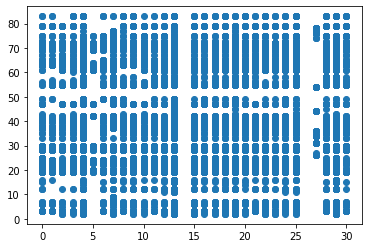

In [10]:
plt.scatter(last_month["city_id"],last_month["item_category_id"])

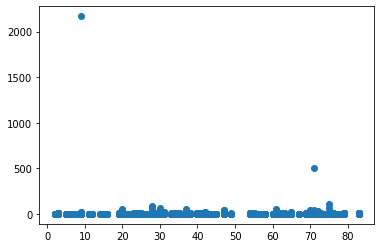

In [12]:
plt.scatter(last_month["item_category_id"],last_month["item_cnt_day"])

In [16]:
df[df["item_category_id"] == 26]
# category 26 did not sell much

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name,shop_name_cleaned,city,city_id
3218854,01.09.2015,32,55,2757,140.0,2.0,"Dead Space [Android, Цифровая версия]",26,Игры Android - Цифра,Цифровой склад 1С-Онлайн,Цифровой склад 1СОнлайн,Цифровой,27
3218833,02.06.2015,29,55,2757,140.0,3.0,"Dead Space [Android, Цифровая версия]",26,Игры Android - Цифра,Цифровой склад 1С-Онлайн,Цифровой склад 1СОнлайн,Цифровой,27
3218832,03.06.2015,29,55,2757,140.0,1.0,"Dead Space [Android, Цифровая версия]",26,Игры Android - Цифра,Цифровой склад 1С-Онлайн,Цифровой склад 1СОнлайн,Цифровой,27
3221202,03.09.2015,32,55,5007,140.0,1.0,"NBA Jam [Android, Цифровая версия]",26,Игры Android - Цифра,Цифровой склад 1С-Онлайн,Цифровой склад 1СОнлайн,Цифровой,27
3218855,03.10.2015,33,55,2757,140.0,2.0,"Dead Space [Android, Цифровая версия]",26,Игры Android - Цифра,Цифровой склад 1С-Онлайн,Цифровой склад 1СОнлайн,Цифровой,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3218813,29.12.2014,23,55,2757,183.2,1.0,"Dead Space [Android, Цифровая версия]",26,Игры Android - Цифра,Цифровой склад 1С-Онлайн,Цифровой склад 1СОнлайн,Цифровой,27
3218519,30.05.2015,28,55,5230,210.0,1.0,"Need for Speed Most Wanted [Android, Цифровая ...",26,Игры Android - Цифра,Цифровой склад 1С-Онлайн,Цифровой склад 1СОнлайн,Цифровой,27
3218820,30.05.2015,28,55,2757,140.0,1.0,"Dead Space [Android, Цифровая версия]",26,Игры Android - Цифра,Цифровой склад 1С-Онлайн,Цифровой склад 1СОнлайн,Цифровой,27
3218522,30.06.2015,29,55,5230,210.0,1.0,"Need for Speed Most Wanted [Android, Цифровая ...",26,Игры Android - Цифра,Цифровой склад 1С-Онлайн,Цифровой склад 1СОнлайн,Цифровой,27


In [18]:
sony_vita = df[df["item_category_id"] == 14]

In [22]:
sony_vita_sales = sony_vita.groupby("date_block_num")["item_cnt_day"].sum()

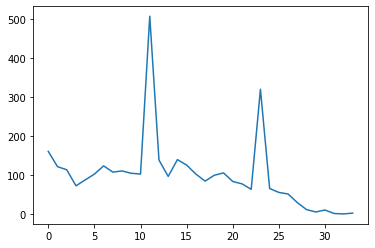

In [23]:
plt.plot(sony_vita_sales)